# Notebook for analyzing synthetic radar results


Before running this notebook, download the pretrained models as described in the `README`


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE'
import sys
sys.path.append('../src/')
import h5py
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Plot metrics

In [3]:
# Read the metrics output during training
log_files= {
    'mse':'/content/drive/MyDrive/neurips-2020-sevir-master/logs/sample-mse/mse-metrics.csv',
    'mse+vgg':'/content/drive/MyDrive/neurips-2020-sevir-master/logs/sample-mse-vgg/mse-vgg-metrics.csv',
    'gan':'/content/drive/MyDrive/neurips-2020-sevir-master/logs/sample-gan-mae/gan-mae-metrics.csv'
}
metrics={ k:pd.read_csv(v) for k,v in log_files.items()}

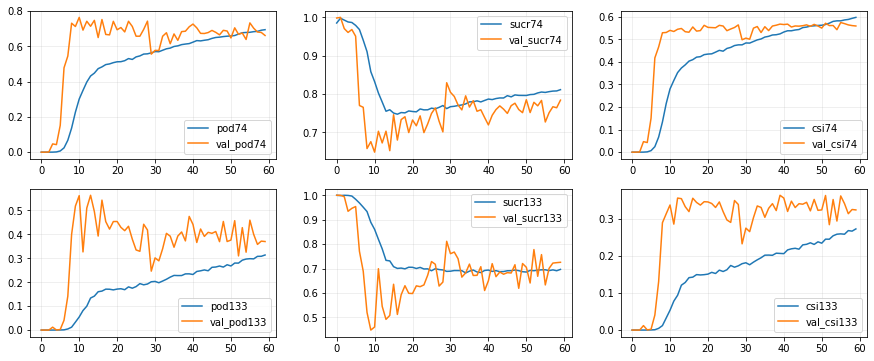

In [4]:
# MSE
fig,ax=plt.subplots(2,3,figsize=(15,6))
def plot_metrics_row(df,metric_names,ax):
    for k,m in enumerate(metric_names):
        df[[m,'val_'+m]].plot(ax=ax[k])
        ax[k].grid(True,alpha=.25)

plot_metrics_row(metrics['mse'],['pod74','sucr74','csi74'],ax[0])
plot_metrics_row(metrics['mse'],['pod133','sucr133','csi133'],ax[1])

With MSE loss, the model converges in relatively few epochs when using the full SEVIR training dataset.  In this case, each epoch represents 75 batches of 32 SEVIR samples.  In this case, roughly 20 epochs seems like enough for peak performance on the validation set (orange line) in a variety of metrics.  The training loss continues to improve over time, but this is likely overfitting based on the stagnant validation curve. 

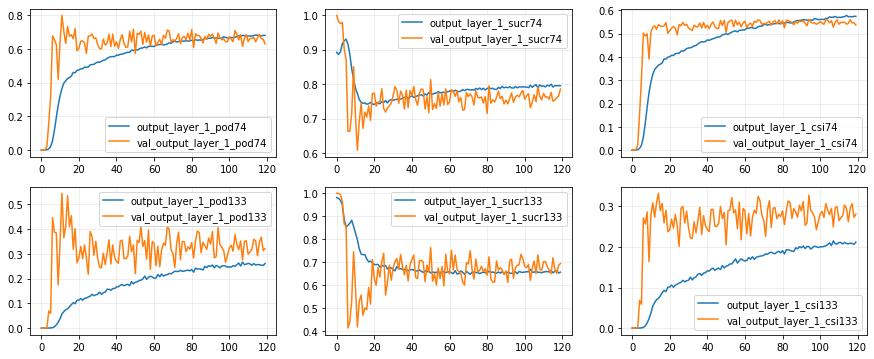

In [5]:
# mse+mse
fig,ax=plt.subplots(2,3,figsize=(15,6))
def plot_metrics_row(df,metric_names,ax):
    for k,m in enumerate(metric_names):
        df[[m,'val_'+m]].plot(ax=ax[k])
        ax[k].grid(True,alpha=.25)

plot_metrics_row(metrics['mse+vgg'],['output_layer_1_pod74','output_layer_1_sucr74','output_layer_1_csi74'],ax[0])
plot_metrics_row(metrics['mse+vgg'],['output_layer_1_pod133','output_layer_1_sucr133','output_layer_1_csi133'],ax[1])

This model also converged in ~20 epochs.

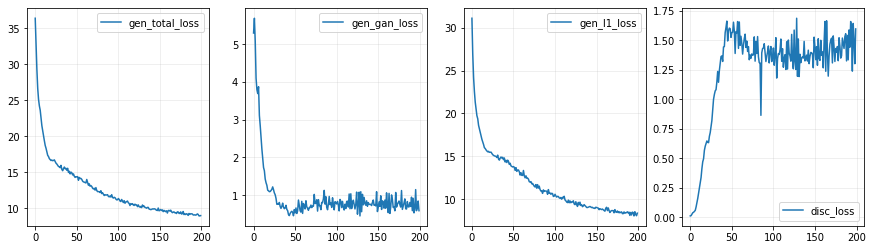

In [6]:
# gan
fig,ax=plt.subplots(1,4,figsize=(15,4))
def plot_metrics_row(df,metrics,ax):
    for k,m in enumerate(metrics):
        df[[m]].plot(ax=ax[k])
        ax[k].grid(True,alpha=.25)

plot_metrics_row(metrics['gan'],['gen_total_loss', 'gen_gan_loss', 'gen_l1_loss', 'disc_loss'],ax)

The four losses involved with training the cGAN version of the loss.  No validation set was used for this experiement.  At around spoch 50, the discriminator started competiting with the generator.   

## Generate sample images

This runs the trained model on samples from the test set.  We will use basic color maps for this demo (if the paper is accepted we will apply the same colormap and style shown in the paper)

In [7]:
# Load weights from best model on val set
mse_weights_file = '/content/drive/MyDrive/neurips-2020-sevir-master/data/mse_weights.h5'
mse_model = tf.keras.models.load_model(mse_weights_file,compile=False,custom_objects={"tf": tf})

mse_vgg_weights_file = '/content/drive/MyDrive/neurips-2020-sevir-master/data/mse_vgg_weights.h5'
mse_vgg_model = tf.keras.models.load_model(mse_vgg_weights_file,compile=False,custom_objects={"tf": tf})

gan_weights_file = '/content/drive/MyDrive/neurips-2020-sevir-master/data/gan_mae_weights.h5'
gan_model = tf.keras.models.load_model(gan_weights_file,compile=False,custom_objects={"tf": tf})

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: models.synrad_unet is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: models.synrad_gan is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


## Load sample test data

To download sample test data, go to https://www.dropbox.com/s/7o3jyeenhrgrkql/synrad_testing.h5?dl=0
 and save file to `data/sample/synrad_testing.h5`

In [8]:
# Load a part of the test dataset
from synrad_reader import read_data
x_test,y_test = read_data('/content/drive/MyDrive/neurips-2020-sevir-master/data/synrad_testing.h5',end=1000)

## Visualize results on some test samples

In [9]:
# Run model on test set
def run_synrad(model,x_test,batch_size=32):
    return model.predict([x_test[k] for k in ['ir069','ir107','lght']],batch_size=batch_size)
y_pred_mse     = run_synrad(mse_model,x_test)
y_pred_mse_vgg = run_synrad(mse_vgg_model,x_test)
y_pred_gan     = run_synrad(gan_model,x_test)

In [10]:
# Plot using default cmap
from display import get_cmap
def visualize_result(y_test,y_preds,idx,ax):
    cmap_dict = lambda s: {'cmap':get_cmap(s,encoded=True)[0], 'norm':get_cmap(s,encoded=True)[1],
                           'vmin':get_cmap(s,encoded=True)[2], 'vmax':get_cmap(s,encoded=True)[3]}
    ax[0].imshow(x_test['ir069'][idx,:,:,0],**cmap_dict('ir069'))
    ax[1].imshow(x_test['ir107'][idx,:,:,0],**cmap_dict('ir107'))
    ax[2].imshow(x_test['lght'][idx,:,:,0],cmap='hot',vmin=0,vmax=10)
    ax[3].imshow(y_test['vil'][idx,:,:,0],**cmap_dict('vil'))
    for k in range(len(y_preds)):
        if isinstance(y_preds[k],(list,)):
            yp=y_preds[k][0]
        else:
            yp=y_preds[k]
        ax[4+k].imshow(yp[idx,:,:,0],**cmap_dict('vil'))
    for i in range(len(ax)):
        ax[i].xaxis.set_ticks([])
        ax[i].yaxis.set_ticks([])
    

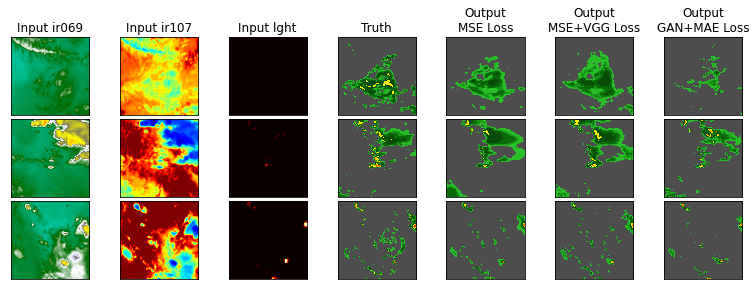

In [11]:
test_idx = [123,456,789]
N=len(test_idx)
fig,ax = plt.subplots(N,7,figsize=(12,4))
for k,i in enumerate(test_idx):
    visualize_result(y_test,[y_pred_mse,y_pred_mse_vgg,y_pred_gan], i, ax[k] )

ax[0][0].set_title('Input ir069')
ax[0][1].set_title('Input ir107')
ax[0][2].set_title('Input lght')
ax[0][3].set_title('Truth')
ax[0][4].set_title('Output\nMSE Loss')
ax[0][5].set_title('Output\nMSE+VGG Loss')
ax[0][6].set_title('Output\nGAN+MAE Loss')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.05,
                    wspace=0.35)
